In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.model_selection

import tpot

In [2]:
MAX_TIME = 5 # minutes
RANDOM_SEED = 1234

In [3]:
csv_files = [i for i in os.listdir() if i.endswith("csv")]
dataframes = [pd.read_csv(file, index_col="Unnamed: 0") for file in csv_files]

experiments = {}
for filename, dataframe in zip(csv_files, dataframes):
    if len(dataframe) > 0:
        experiments[filename] = dataframe
print("\n".join(experiments.keys()))

both_UWBGOnly.csv
both_WBGOnly.csv
both_carbidesOnly.csv
both_chalcogensOnly.csv
both_conventionalSemiconductorsOnly.csv
both_extra_descriptors.csv
both_halidesOnly.csv
both_nitridesOnly.csv
both_oxidesOnly.csv
both_pBlockMetalsOnly.csv
both_pnictogensOnly.csv
both_sulfidesOnly.csv


In [4]:
targets = ["bandgap (eV)", "exfoliation_energy_per_atom (eV/atom)"]
n_models = len(experiments.keys()) * len(targets)

print(f"Estimated time to evaluate all {n_models} scenarios, budgeting {MAX_TIME} minutes per model: {n_models * MAX_TIME} minutes")

Estimated time to evaluate all 24 scenarios, budgeting 5 minutes per model: 120 minutes


In [5]:
def experiment_generator():
    for name, df in experiments.items():
        for target in targets:
            yield name, df, target
experiment = experiment_generator()

def run_experiment(name, df, target):
    test_size = 0.1
    regression_irrelevant = [
        '2dm_id (unitless)',
        'formula',
        'discovery_process (unitless)',
        'potcars (unitless)',
        'is_hubbard (unitless)',
        'energy_per_atom (eV)',
        'decomposition_energy (eV/atom)',
        'is_bandgap_direct (unitless)',
        'is_metal (unitless)',
        'energy_vdw_per_atom (eV/atom)',
        'total_magnetization (Bohr Magneton)']
    
    # Ignore other target columns
    other_targets = [col for col in targets if col != target]
    df = df.drop(columns=other_targets + regression_irrelevant)
    
    # Train / Test Split
    data_train, data_test = sklearn.model_selection.train_test_split(df, test_size=test_size, random_state=RANDOM_SEED)
    train_x = data_train.drop(columns=target).to_numpy()
    train_y = data_train[target].to_numpy()
    
    test_x = data_test.drop(columns=target).to_numpy()
    test_y = data_test[target].to_numpy()
    
    # Train a model
    model = tpot.TPOTRegressor(
        generations=None,
        population_size=100,
        max_eval_time_mins=5/60,
        max_time_mins=MAX_TIME,
        cv=4,
        verbosity=2,
        scoring="r2",
        config_dict=tpot.config.regressor_config_dict,
        n_jobs=22,
        random_state=RANDOM_SEED
    )
    model.fit(features=train_x, target=train_y)
    
    train_y_pred = model.predict(train_x)
    test_y_pred = model.predict(test_x)
    
    print("Test-Set Error Metrics:")
    for name, metric in [
        ["MAE", sklearn.metrics.mean_absolute_error],
        ["MAPE", sklearn.metrics.mean_absolute_percentage_error],
        ["MSE", sklearn.metrics.mean_squared_error],
        ["R2", sklearn.metrics.r2_score],
        ["Max Error", sklearn.metrics.max_error]
    ]:
        print(f"{name}: {np.round(metric(y_true=test_y, y_pred=test_y_pred), 3)}")
    
    # Plot the results   
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.rcParams["figure.figsize"] = (10,10)
    plt.rcParams["font.size"] = 16

    plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
    plt.scatter(x=test_y_pred, y=test_y, label="Test Set")
    
    min_xy = min(min(train_y_pred), min(train_y))
    max_xy = max(max(train_y_pred), max(train_y))
    
    plt.plot([min_xy,max_xy], [min_xy,max_xy], label="Parity")
    plt.ylabel(f"{target} (Dataset)")
    plt.xlabel(f"{target} (Predicted)")
    plt.legend()
    plt.show()

Name: both_UWBGOnly.csv
Rows: 58
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5369453049906889

Generation 2 - Current best internal CV score: 0.5369453049906889

Generation 3 - Current best internal CV score: 0.6137979213306674

Generation 4 - Current best internal CV score: 0.6266259788912136

Generation 5 - Current best internal CV score: 0.6371346109677712

5.04 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(AdaBoostRegressor(Normalizer(input_matrix, norm=max), learning_rate=0.001, loss=linear, n_estimators=100), normalize=True)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.328
MAPE: 0.073
MSE: 0.127
R2: 0.831
Max Error: 0.609


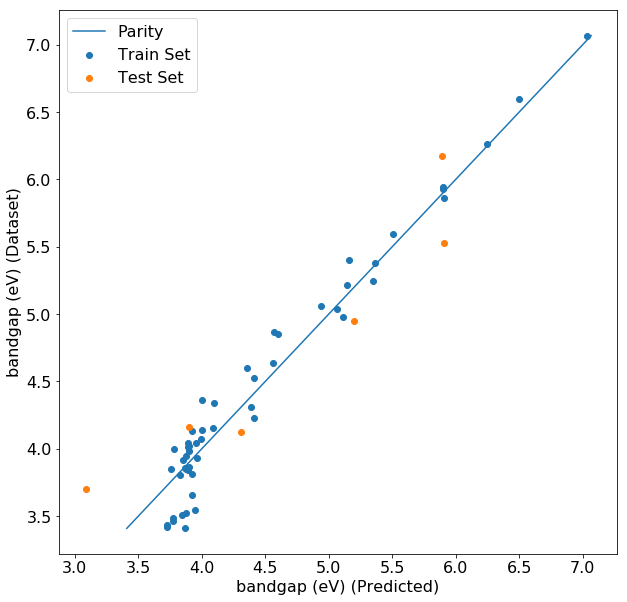

In [6]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_UWBGOnly.csv
Rows: 58
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.30949324165588815

Generation 2 - Current best internal CV score: 0.32373692569124457

Generation 3 - Current best internal CV score: 0.32373692569124457

Generation 4 - Current best internal CV score: 0.3338495173216749

Generation 5 - Current best internal CV score: 0.3477339418162265

5.06 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.001, loss=square, n_estimators=100), learning_rate=0.01, loss=linear, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.028
MAPE: 0.277
MSE: 0.003
R2: 0.047
Max Error: 0.124


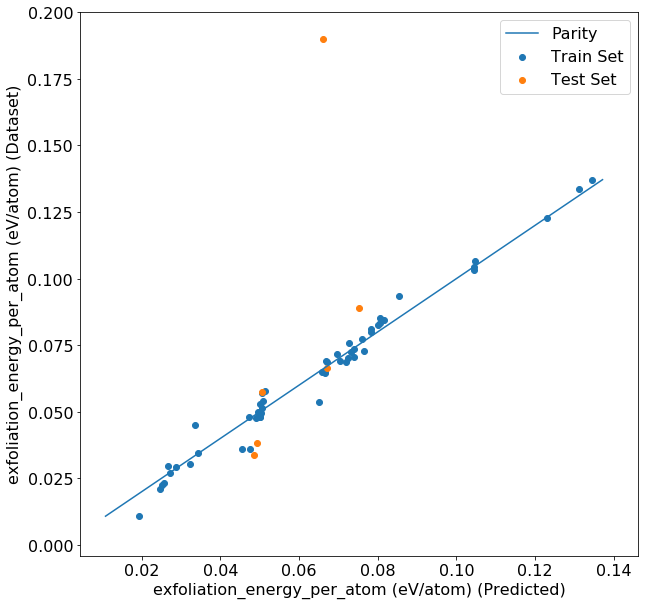

In [7]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_WBGOnly.csv
Rows: 79
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.09683947306002588

Generation 2 - Current best internal CV score: 0.09683947306002588

Generation 3 - Current best internal CV score: 0.10050947851986972

Generation 4 - Current best internal CV score: 0.10050947851986972

Generation 5 - Current best internal CV score: 0.10795615622763235

Generation 6 - Current best internal CV score: 0.10795615622763235

Generation 7 - Current best internal CV score: 0.1198212388543328

Generation 8 - Current best internal CV score: 0.1198212388543328

5.10 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(RobustScaler(VarianceThreshold(input_matrix, threshold=0.005)), bootstrap=False, max_features=0.5, min_samples_leaf=20, min_samples_split=20, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metri

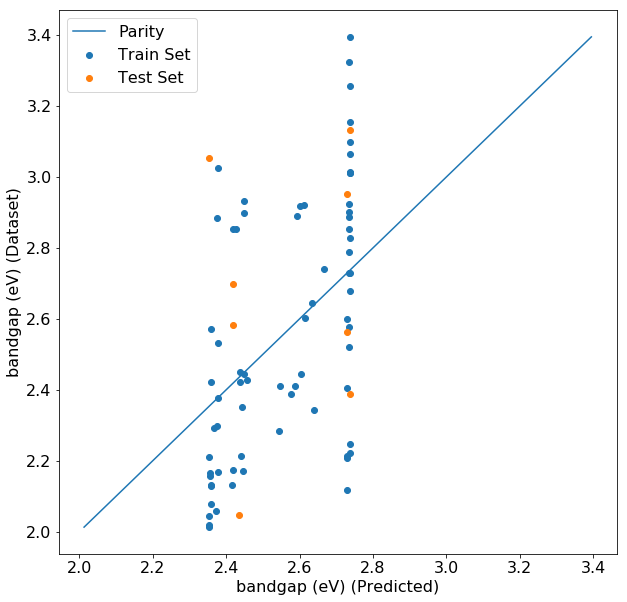

In [8]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_WBGOnly.csv
Rows: 79
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.2771424687575984

Generation 2 - Current best internal CV score: 0.2804116340800409

Generation 3 - Current best internal CV score: 0.2804116340800409

Generation 4 - Current best internal CV score: 0.32359602698318857

Generation 5 - Current best internal CV score: 0.32359602698318857

5.36 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(StandardScaler(input_matrix), bootstrap=False, max_features=0.3, min_samples_leaf=12, min_samples_split=11, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.032
MAPE: 0.42
MSE: 0.002
R2: -0.208
Max Error: 0.114


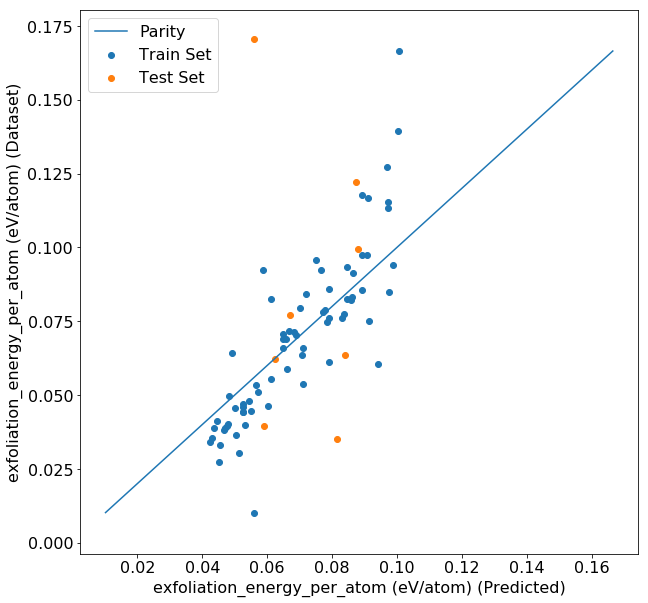

In [9]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

In [10]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_carbidesOnly.csv
Rows: 3
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]

Something went wrong, continuing down to the other experiments. Traceback:
A pipeline has not yet been optimized. Please call fit() first.


In [11]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_carbidesOnly.csv
Rows: 3
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]

Something went wrong, continuing down to the other experiments. Traceback:
A pipeline has not yet been optimized. Please call fit() first.


Name: both_chalcogensOnly.csv
Rows: 215
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7720289297410285

Generation 2 - Current best internal CV score: 0.7720289297410285

Generation 3 - Current best internal CV score: 0.7720289297410285

Generation 4 - Current best internal CV score: 0.7720289297410285

Generation 5 - Current best internal CV score: 0.7720289297410285

Generation 6 - Current best internal CV score: 0.7720289297410285

5.12 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(ElasticNetCV(input_matrix, l1_ratio=0.75, tol=0.1), learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.714
MAPE: 1.847
MSE: 1.368
R2: 0.474
Max Error: 3.592


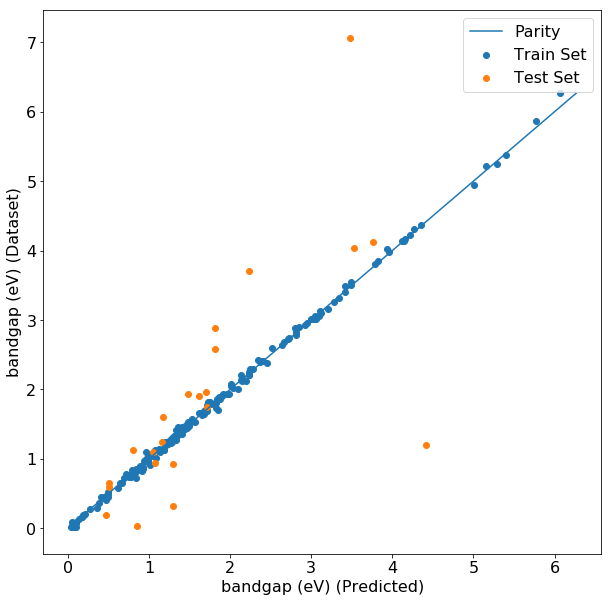

In [12]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_chalcogensOnly.csv
Rows: 215
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3522450900295255

Generation 2 - Current best internal CV score: 0.3619514501024149

Generation 3 - Current best internal CV score: 0.3619514501024149

Generation 4 - Current best internal CV score: 0.3620681920101949

Generation 5 - Current best internal CV score: 0.3700671809792021

Generation 6 - Current best internal CV score: 0.3700671809792021

Generation 7 - Current best internal CV score: 0.3994361650635796

5.26 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(XGBRegressor(KNeighborsRegressor(input_matrix, n_neighbors=35, p=1, weights=uniform), learning_rate=0.1, max_depth=10, min_child_weight=8, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0), bootstrap=False, max_features=1.0, min_samples_leaf=4, min_samples_split=8, n_estimators=100)
Imputing missin

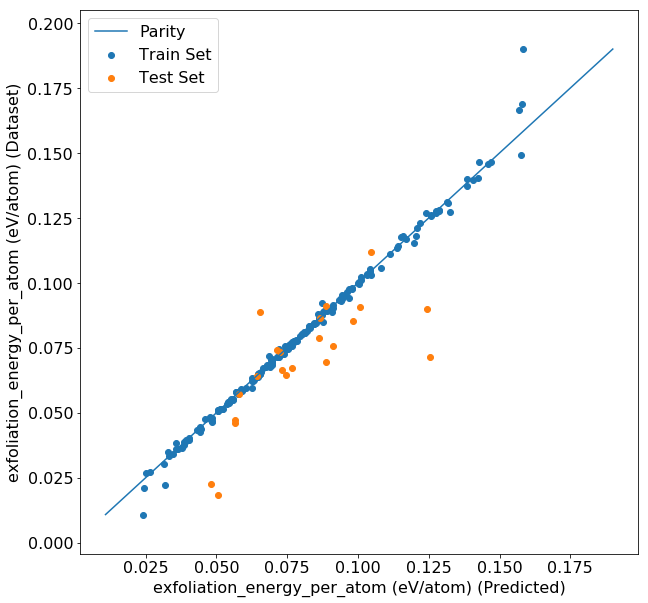

In [13]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_conventionalSemiconductorsOnly.csv
Rows: 250
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3903858106329973

Generation 2 - Current best internal CV score: 0.3903858106329973

Generation 3 - Current best internal CV score: 0.3903858106329973

Generation 4 - Current best internal CV score: 0.3903858106329973

Generation 5 - Current best internal CV score: 0.3903858106329973

Generation 6 - Current best internal CV score: 0.40656951791207097

Generation 7 - Current best internal CV score: 0.40656951791207097

5.09 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(SelectPercentile(input_matrix, percentile=3), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.319
MAPE: 1.314
MSE: 0.155
R2: 0.567
Max Error: 0.871


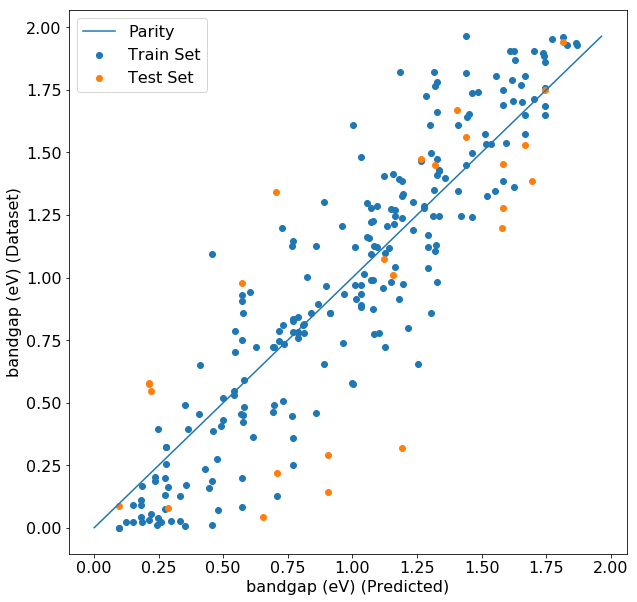

In [14]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_conventionalSemiconductorsOnly.csv
Rows: 250
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3570446752748373

Generation 2 - Current best internal CV score: 0.377341066957173

Generation 3 - Current best internal CV score: 0.377341066957173

Generation 4 - Current best internal CV score: 0.377341066957173

Generation 5 - Current best internal CV score: 0.39105363363143486

Generation 6 - Current best internal CV score: 0.39105363363143486

Generation 7 - Current best internal CV score: 0.39105363363143486

5.38 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(CombineDFs(input_matrix, input_matrix), learning_rate=1.0, loss=square, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.016
MAPE: 0.225
MSE: 0.0
R2: 0.161
Max Error: 0.06


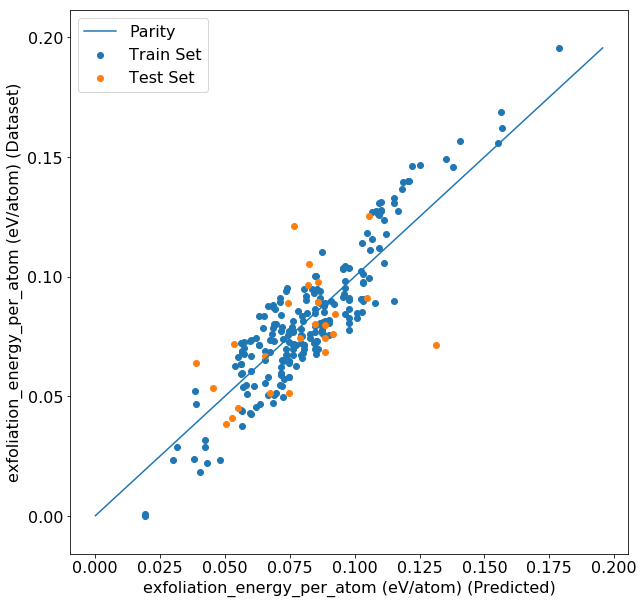

In [15]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_extra_descriptors.csv
Rows: 387
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6837391471546101

Generation 2 - Current best internal CV score: 0.6837391471546101

Generation 3 - Current best internal CV score: 0.6955903357946831

Generation 4 - Current best internal CV score: 0.7051662499789203

Generation 5 - Current best internal CV score: 0.7051662499789203

5.09 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(ZeroCount(input_matrix), learning_rate=0.5, max_depth=4, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.652
MAPE: 1.814
MSE: 0.915
R2: 0.434
Max Error: 3.572


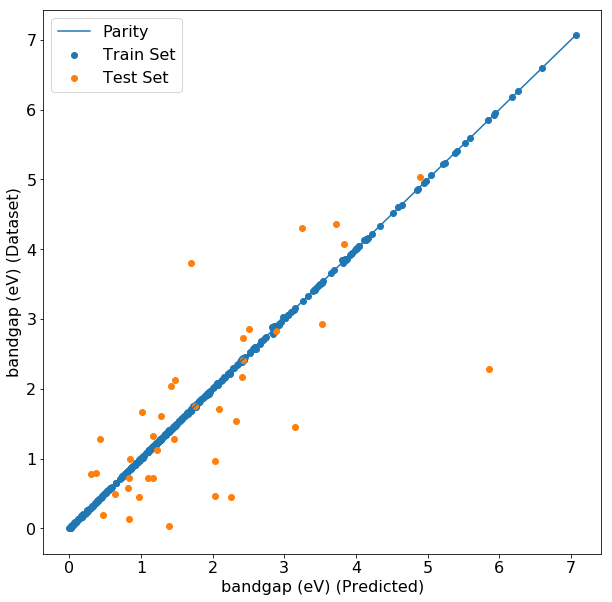

In [16]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_extra_descriptors.csv
Rows: 387
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.4515256944745114

Generation 2 - Current best internal CV score: 0.4515256944745114

Generation 3 - Current best internal CV score: 0.4515256944745114

Generation 4 - Current best internal CV score: 0.4515256944745114

Generation 5 - Current best internal CV score: 0.4515256944745114

Generation 6 - Current best internal CV score: 0.4515256944745114

Generation 7 - Current best internal CV score: 0.4515256944745114

5.06 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=5, min_child_weight=18, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8500000000000001, verbosity=0)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.016
MAPE: 1.959
MSE: 0.001
R2: 0.42
Max Error: 0.074


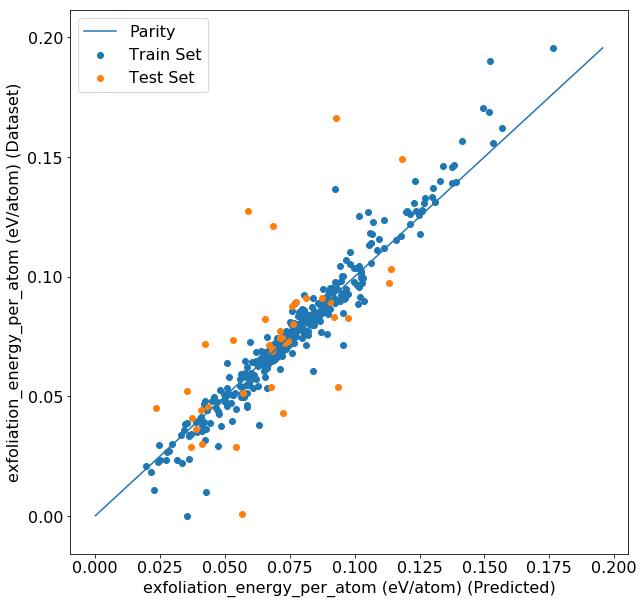

In [17]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_halidesOnly.csv
Rows: 173
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5527953447701963

Generation 2 - Current best internal CV score: 0.5527953447701963

Generation 3 - Current best internal CV score: 0.5527953447701963

Generation 4 - Current best internal CV score: 0.5621736601066998

Generation 5 - Current best internal CV score: 0.5621736601066998

Generation 6 - Current best internal CV score: 0.5621736601066998

5.34 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(SelectFwe(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), alpha=0.023), learning_rate=1.0, loss=linear, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.586
MAPE: 33.034
MSE: 0.678
R2: 0.74
Max Error: 1.935


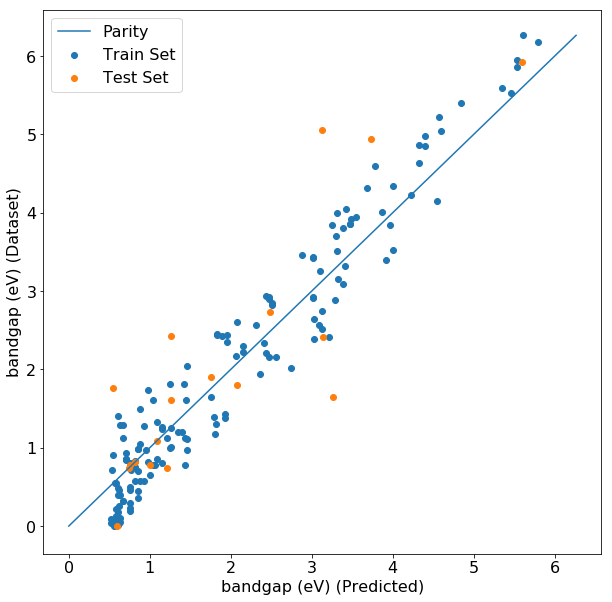

In [18]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_halidesOnly.csv
Rows: 173
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.17096557743057877

Generation 2 - Current best internal CV score: 0.17096557743057877

Generation 3 - Current best internal CV score: 0.18615783137131575

Generation 4 - Current best internal CV score: 0.19656622356498582

Generation 5 - Current best internal CV score: 0.19656622356498582

5.03 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(GradientBoostingRegressor(GradientBoostingRegressor(input_matrix, alpha=0.9, learning_rate=0.1, loss=ls, max_depth=3, max_features=0.6500000000000001, min_samples_leaf=3, min_samples_split=6, n_estimators=100, subsample=0.25), alpha=0.9, learning_rate=1.0, loss=lad, max_depth=9, max_features=0.55, min_samples_leaf=16, min_samples_split=20, n_estimators=100, subsample=0.6500000000000001), bootstrap=True, max_features=0.5, min_samples_leaf=9, min_samples_split

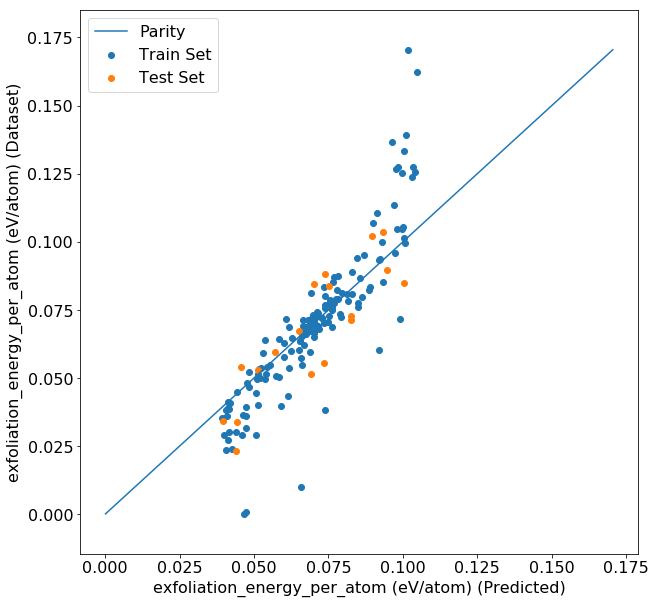

In [19]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_nitridesOnly.csv
Rows: 16
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3.934548486163021

Generation 2 - Current best internal CV score: -3.934548486163021

Generation 3 - Current best internal CV score: -3.934548486163021

Generation 4 - Current best internal CV score: -3.934548486163021

Generation 5 - Current best internal CV score: -3.7655750246911057

Generation 6 - Current best internal CV score: -3.7655750246911057

Generation 7 - Current best internal CV score: -3.695539741432723

Generation 8 - Current best internal CV score: -3.695539741432723

Generation 9 - Current best internal CV score: -3.695539741432723

Generation 10 - Current best internal CV score: -3.315881450300799

Generation 11 - Current best internal CV score: -3.315881450300799

Generation 12 - Current best internal CV score: -3.315881450300799

Generation 13 - Current best internal CV score: -3.2944503101833584

5.02 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed premature

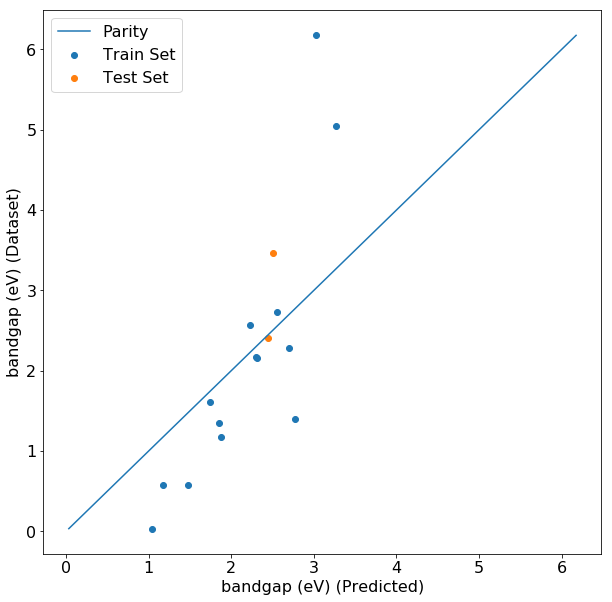

In [20]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_nitridesOnly.csv
Rows: 16
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.2119891589440886

Generation 2 - Current best internal CV score: -0.2119891589440886

Generation 3 - Current best internal CV score: -0.2119891589440886

Generation 4 - Current best internal CV score: -0.2119891589440886

Generation 5 - Current best internal CV score: -0.17611842206806413

Generation 6 - Current best internal CV score: 0.18911902813742798

Generation 7 - Current best internal CV score: 0.22221169686281206

Generation 8 - Current best internal CV score: 0.22221169686281206

Generation 9 - Current best internal CV score: 0.22221169686281206

Generation 10 - Current best internal CV score: 0.22221169686281206

5.17 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeRegressor(PolynomialFeatures(ZeroCount(input_matrix), degree=2, include_bias=False, interaction_only=False), max_depth=3, min_sa

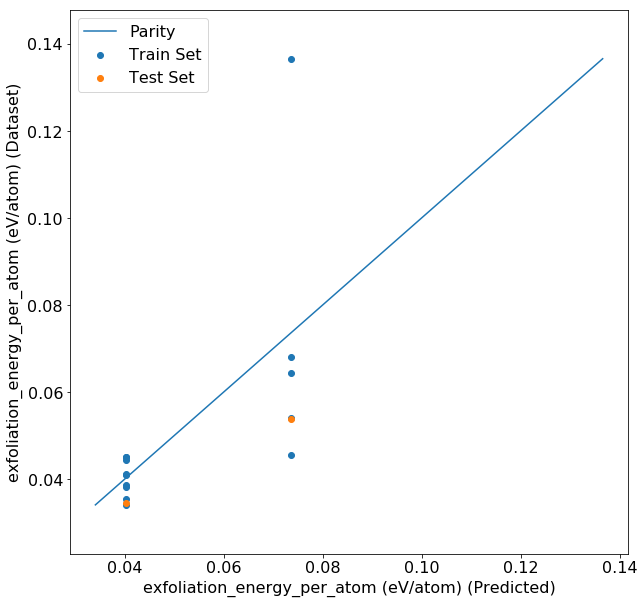

In [21]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_oxidesOnly.csv
Rows: 66
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.48469753801449744

Generation 2 - Current best internal CV score: 0.48469753801449744

Generation 3 - Current best internal CV score: 0.48469753801449744

Generation 4 - Current best internal CV score: 0.5220167747610333

Generation 5 - Current best internal CV score: 0.5336255347202563

5.07 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(ElasticNetCV(input_matrix, l1_ratio=0.35000000000000003, tol=0.001), learning_rate=1.0, loss=linear, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 1.067
MAPE: 0.471
MSE: 1.646
R2: 0.454
Max Error: 2.418


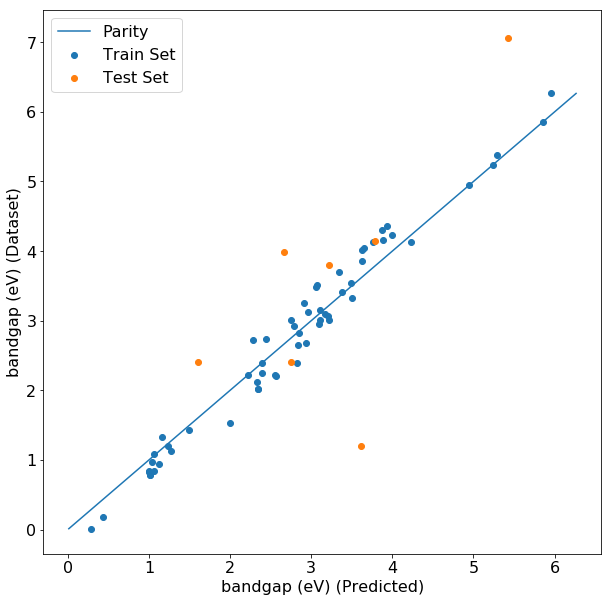

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_oxidesOnly.csv
Rows: 66
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.1881435475966814

Generation 2 - Current best internal CV score: 0.20391080834008854

Generation 3 - Current best internal CV score: 0.20391080834008854

Generation 4 - Current best internal CV score: 0.20853744784773875

Generation 5 - Current best internal CV score: 0.2100527979190192

Generation 6 - Current best internal CV score: 0.2574388375656168

5.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesRegressor(RandomForestRegressor(input_matrix, bootstrap=False, max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=100), bootstrap=False, max_features=1.0, min_samples_leaf=10, min_samples_split=5, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.032
MAPE: 0.734
MSE: 0.001
R2: -0.28
Max Error: 0.063


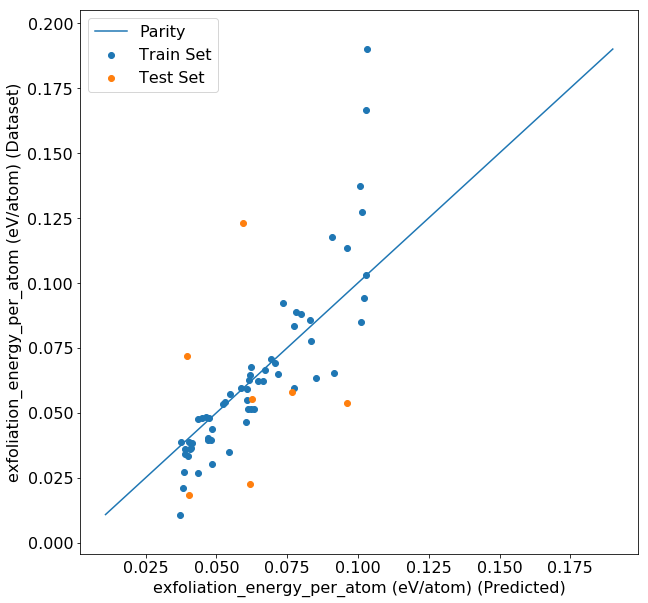

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_pBlockMetalsOnly.csv
Rows: 115
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5209072511163868

Generation 2 - Current best internal CV score: 0.5209072511163868

Generation 3 - Current best internal CV score: 0.5284403650185696

Generation 4 - Current best internal CV score: 0.5606449007122084

Generation 5 - Current best internal CV score: 0.5606449007122084

Generation 6 - Current best internal CV score: 0.5606449007122084

Generation 7 - Current best internal CV score: 0.5606449007122084

5.22 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(SelectPercentile(input_matrix, percentile=41), bootstrap=False, max_features=0.9500000000000001, min_samples_leaf=4, min_samples_split=20, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.821
MAPE: 1.762
MSE: 1.187
R2: 0.138
Max Error: 2.838


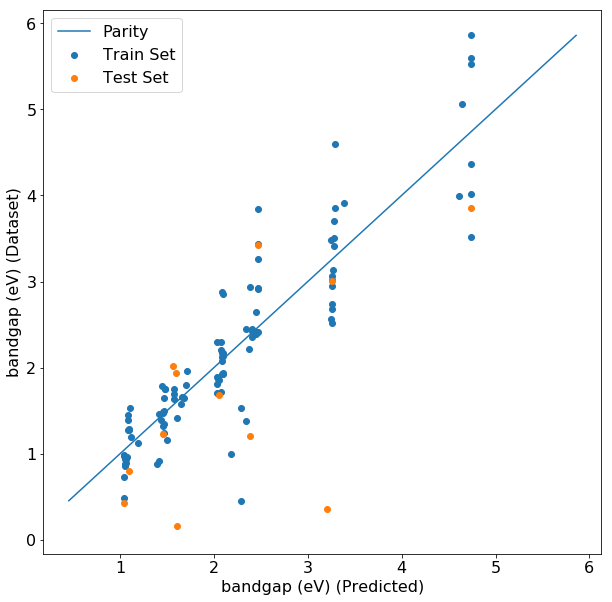

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_pBlockMetalsOnly.csv
Rows: 115
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.2287650942171114

Generation 2 - Current best internal CV score: 0.2287650942171114

Generation 3 - Current best internal CV score: 0.2287650942171114

Generation 4 - Current best internal CV score: 0.2287650942171114

Generation 5 - Current best internal CV score: 0.24467341604725956

Generation 6 - Current best internal CV score: 0.24467341604725956

5.68 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: AdaBoostRegressor(RobustScaler(ZeroCount(input_matrix)), learning_rate=0.1, loss=linear, n_estimators=100)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.018
MAPE: 0.292
MSE: 0.0
R2: 0.458
Max Error: 0.047


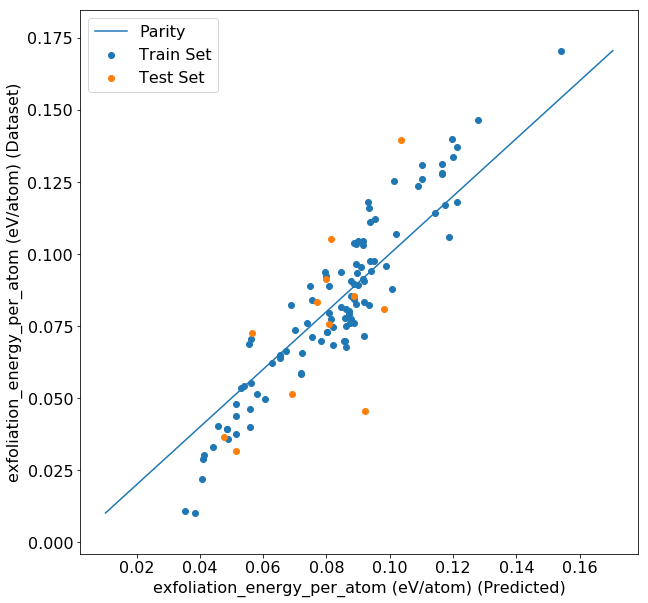

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_pnictogensOnly.csv
Rows: 99
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.29467648905938654

Generation 2 - Current best internal CV score: 0.29467648905938654

Generation 3 - Current best internal CV score: 0.3515149852146803

Generation 4 - Current best internal CV score: 0.3515149852146803

Generation 5 - Current best internal CV score: 0.3641354634154449

5.07 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: SGDRegressor(XGBRegressor(VarianceThreshold(MaxAbsScaler(input_matrix), threshold=0.0005), learning_rate=0.001, max_depth=4, min_child_weight=19, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0), alpha=0.001, eta0=0.01, fit_intercept=False, l1_ratio=1.0, learning_rate=invscaling, loss=squared_loss, penalty=elasticnet, power_t=0.0)
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 1.017
MAPE

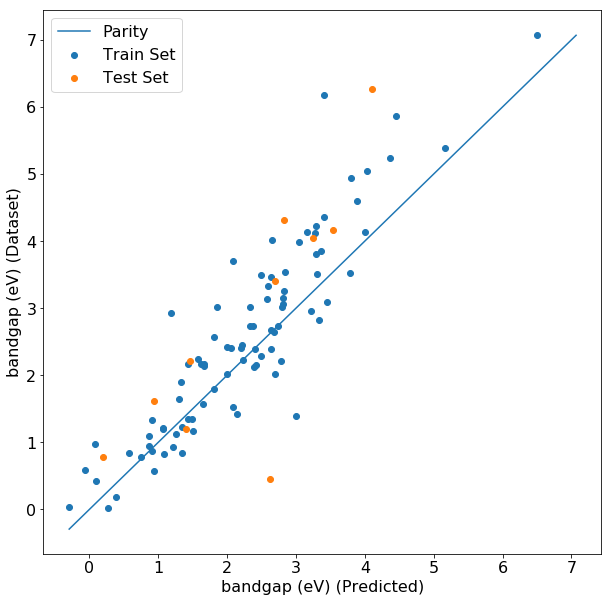

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_pnictogensOnly.csv
Rows: 99
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.2423616834349702

Generation 2 - Current best internal CV score: 0.2423616834349702

Generation 3 - Current best internal CV score: 0.2423616834349702

Generation 4 - Current best internal CV score: 0.2423616834349702

Generation 5 - Current best internal CV score: 0.24999164543776956

Generation 6 - Current best internal CV score: 0.24999164543776956

Generation 7 - Current best internal CV score: 0.24999164543776956

Generation 8 - Current best internal CV score: 0.2892507652541677

5.02 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(GradientBoostingRegressor(MinMaxScaler(input_matrix), alpha=0.99, learning_rate=1.0, loss=lad, max_depth=4, max_features=0.6000000000000001, min_samples_leaf=19, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001), bootstrap=True, max_features=

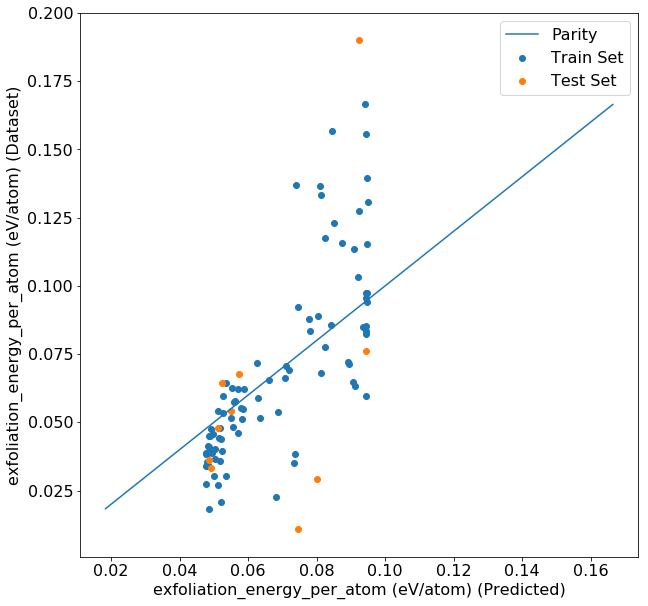

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_sulfidesOnly.csv
Rows: 65
Target: bandgap (eV)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.48182321696430064

Generation 2 - Current best internal CV score: 0.6354743811970113

Generation 3 - Current best internal CV score: 0.6354743811970113

Generation 4 - Current best internal CV score: 0.6354743811970113

Generation 5 - Current best internal CV score: 0.6358400459375934

Generation 6 - Current best internal CV score: 0.6358400459375934

Generation 7 - Current best internal CV score: 0.6868098052306002

5.26 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RidgeCV(Binarizer(input_matrix, threshold=0.35000000000000003))
Imputing missing values in feature set
Imputing missing values in feature set
Test-Set Error Metrics:
MAE: 0.4
MAPE: 0.234
MSE: 0.299
R2: 0.494
Max Error: 1.044


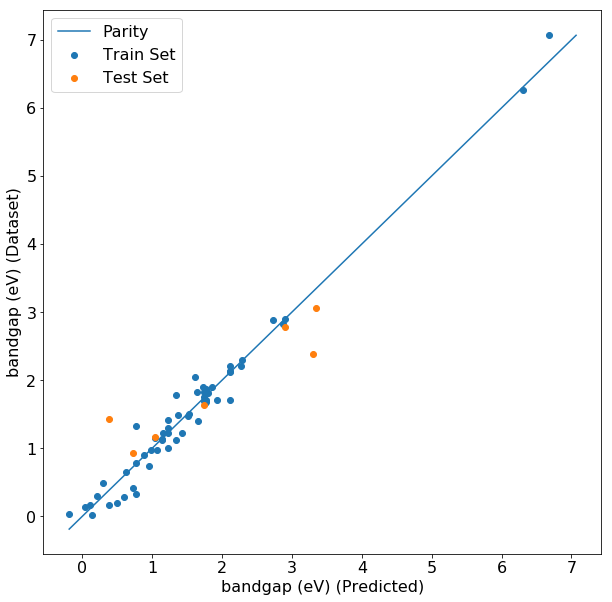

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)

Name: both_sulfidesOnly.csv
Rows: 65
Target: exfoliation_energy_per_atom (eV/atom)
Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.14311310325645876

Generation 2 - Current best internal CV score: 0.1509764835563549

Generation 3 - Current best internal CV score: 0.1509764835563549

Generation 4 - Current best internal CV score: 0.1509764835563549

Generation 5 - Current best internal CV score: 0.1509764835563549

Generation 6 - Current best internal CV score: 0.1509764835563549

Generation 7 - Current best internal CV score: 0.1509764835563549

Generation 8 - Current best internal CV score: 0.1509764835563549

5.35 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: SGDRegressor(Nystroem(PCA(MaxAbsScaler(input_matrix), iterated_power=4, svd_solver=randomized), gamma=0.8, kernel=cosine, n_components=7), alpha=0.001, eta0=0.1, fit_intercept=True, l1_ratio=0.0, learning_rate=constant, loss=huber, penalty=elasticnet, power_t=50.0)
Imputing missing va

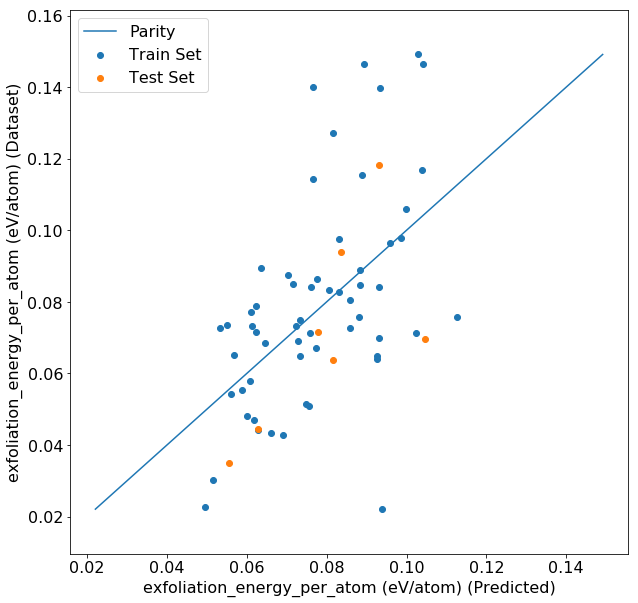

In [ ]:
name, df, target = next(experiment)
print(f"Name: {name}")
print(f"Rows: {len(df)}")
print(f"Target: {target}")
try:
    run_experiment(name, df, target)
except Exception as e:
    print("Something went wrong, continuing down to the other experiments. Traceback:")
    print(e)